# Figures

## Setup

### Import libraries


In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import ticker
from matplotlib.offsetbox import AnchoredText
from statsmodels.formula.api import ols

from functions.data_etl.file_io import read_gdf_from_csv
from functions.data_etl.geocoding import get_continent_from_country
from functions.figures.figures import (
    calculate_pp_increased_ws_share,
    calculate_total_data_center_capacity_at_risk,
    calculate_water_use_by_basin,
    plot_exacerbate_tip_water_scarcity_barchart,
    plot_relative_increase_ws_map,
    plot_water_scarcity_at_extraction_sites,
    plot_water_use_map,
)
from functions.project_settings import (
    GLOBAL_WARMING_SCENARIOS,
    GLOBAL_WARMING_SCENARIOS_FUTURE,
    WGS84_CRS,
)


/Users/audreywientjes/Library/CloudStorage/OneDrive-UniversiteitLeiden/Audrey_Thesis/data-center-water-footprint/.venv/lib/python3.13/site-packages/geocoder/uscensus.py:36: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('^\d+', self.address, re.UNICODE)


## Setting input and output paths


In [3]:
# Input paths
INPUTS_DIR = Path("data/inputs/4_figures/")
RESULTS_DIR = Path("data/outputs/")
COUNTRIES_PATH = Path("data/inputs/common/country_boundaries/ne_110m_admin_0_countries.shp")

# Output paths
FIGURES_DIR = Path("data/outputs/figures")

## Import data

In [4]:
# Read in the country boundaries
country_boundaries = gpd.read_file(COUNTRIES_PATH)

water_scarcity_summary = {
    scenario: read_gdf_from_csv(f"{RESULTS_DIR}/3_water_scarcity/water_scarcity_summary_{scenario}.csv")
    for scenario in GLOBAL_WARMING_SCENARIOS
}

# Filter the dataframes to only include data centers
water_scarcity_summary_dc = {key: val[val["type"] == "data_center"] for key, val in water_scarcity_summary.items()}

# Filter the dataframes to only include power plants
water_scarcity_summary_pp = {key: val[val["type"] != "data_center"] for key, val in water_scarcity_summary.items()}

# Import power plant data
power_plants = read_gdf_from_csv(RESULTS_DIR / "2_energy_and_water_use/power_plants_water_use_baseline.csv")

# Import data center data without scenarios
data_centers = read_gdf_from_csv(RESULTS_DIR / "2_energy_and_water_use/data_centers_no_scenarios.csv")

# Read in the data center electricity and water use data
data_center_energy_water_use = read_gdf_from_csv(
    RESULTS_DIR / "2_energy_and_water_use/data_centers_total_water_use.csv"
)

# Import vulnerability data
vulnerability_summary = read_gdf_from_csv(RESULTS_DIR / "3_water_scarcity/water_scarcity_summary_all.csv")

## Sensitivity Analyses


### Global electricity and water boxplots across all scenario combinations


In [4]:
# Load summary statistics
summary = pd.read_csv(RESULTS_DIR / "2_energy_and_water_use/data_centers_water_electricity_use_summary.csv")

In [5]:
# Create subsets of the data
only_operational_true = summary[summary["only_operational"]]
only_operational_false = summary[~summary["only_operational"]]

# Find the baseline scenario values
baseline_all_scenarios_operational = only_operational_true.query(
    'cooling_tech_scenario == "baseline" and tech_performance == "medium" and power_scenario == "avg"'
)

baseline_all_scenarios_planned = only_operational_false.query(
    'cooling_tech_scenario == "baseline" and tech_performance == "medium" and power_scenario == "avg"'
)


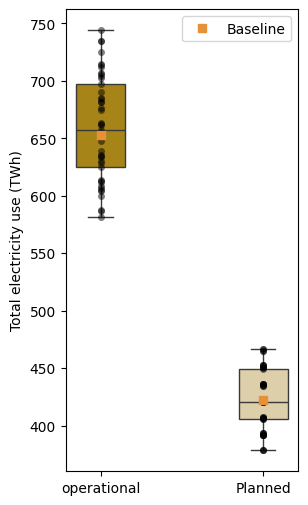

In [6]:
# Create a boxplot showing the total_electricity_use_TWh in the two cases
plt.figure(figsize=(3, 6))
sns.boxplot(
    x=["operational" if val else "Planned" for val in summary["only_operational"]],
    y=[
        row["total_electricity_use_TWh"] if row["only_operational"] else row["marginal_electricity_increase_TWh"]
        for _, row in summary.iterrows()
    ],
    hue=["operational" if val else "Planned" for val in summary["only_operational"]],
    palette=["#e4d3a2", "#bf9000"],
    width=0.3,
    legend=False,
)
sns.stripplot(
    x=["operational" if val else "Planned" for val in summary["only_operational"]],
    y=[
        row["total_electricity_use_TWh"] if row["only_operational"] else row["marginal_electricity_increase_TWh"]
        for _, row in summary.iterrows()
    ],
    color="black",
    alpha=0.5,
    jitter=False,
)
plt.ylabel("Total electricity use (TWh)")
plt.gca().invert_xaxis()

# plot the baseline scenario values in orange squares
plt.plot(
    1,
    baseline_all_scenarios_operational["total_electricity_use_TWh"],
    "s",
    color="#e69138",
    label="Baseline",
    markersize=6,
    zorder=5,
)
plt.plot(
    0, baseline_all_scenarios_planned["marginal_electricity_increase_TWh"], "s", color="#e69138", markersize=6, zorder=5
)
plt.legend()

plt.savefig(FIGURES_DIR / "electricity_use_boxplot.png", dpi=300)

In [7]:
# Replace the total values with the marginal values when only_operational is false
summary = summary.copy()
summary["total_water_use_m3"] = np.where(
    summary["only_operational"], summary["total_water_use_m3"], summary["marginal_total_water_increase_m3"]
)
summary["indirect_water_use_m3"] = np.where(
    summary["only_operational"], summary["indirect_water_use_m3"], summary["marginal_indirect_water_increase_m3"]
)
summary["direct_water_use_m3"] = np.where(
    summary["only_operational"], summary["direct_water_use_m3"], summary["marginal_direct_water_increase_m3"]
)

# Melt the dataframe to have a long format for seaborn
melted_df = summary.melt(
    id_vars=["only_operational"],
    value_vars=["total_water_use_m3", "direct_water_use_m3", "indirect_water_use_m3"],
    var_name="Water Use Type",
    value_name="Water Use (billion m3)",
)

# Map the 'Water Use Type' column to more descriptive labels
melted_df["Water Use Type"] = melted_df["Water Use Type"].map(
    {"direct_water_use_m3": "Direct", "indirect_water_use_m3": "Indirect", "total_water_use_m3": "Total"}
)

# Map the 'only_operational' column to more descriptive labels
melted_df["operational_status"] = melted_df["only_operational"].map({True: "operational", False: "Planned"})

# Set the order of the categories
melted_df["operational_status"] = pd.Categorical(
    melted_df["operational_status"], categories=["operational", "Planned"], ordered=True
)
melted_df["Water Consumption Type"] = pd.Categorical(
    melted_df["Water Use Type"], categories=["Direct", "Indirect", "Total"], ordered=True
)

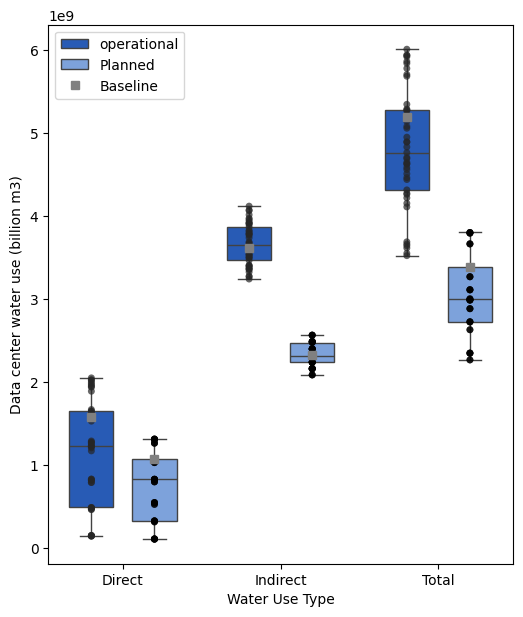

In [8]:
# Create a boxplot of water use
plt.figure(figsize=(6, 7))
sns.boxplot(
    x="Water Use Type",
    y="Water Use (billion m3)",
    hue="operational_status",
    data=melted_df,
    palette=["#1155cc", "#6d9eeb"],
    order=["Direct", "Indirect", "Total"],
    hue_order=["operational", "Planned"],
    gap=0.3,
)
sns.stripplot(
    x="Water Use Type",
    y="Water Use (billion m3)",
    hue="operational_status",
    data=melted_df,
    palette="dark:black",
    alpha=0.7,
    jitter=False,
    dodge=True,
    order=["Direct", "Indirect", "Total"],
    hue_order=["operational", "Planned"],
    legend=False,
)

# Plot the baseline scenario values in squares
plt.plot(
    [-0.2],
    baseline_all_scenarios_operational["direct_water_use_m3"],
    "s",
    color="grey",
    label="Baseline",
    markersize=6,
    zorder=5,
)
plt.plot(
    [0.2],
    baseline_all_scenarios_planned["marginal_direct_water_increase_m3"],
    "s",
    color="grey",
    markersize=6,
    zorder=5,
)
plt.plot([0.8], baseline_all_scenarios_operational["indirect_water_use_m3"], "s", color="grey", markersize=6, zorder=5)
plt.plot(
    [1.2],
    baseline_all_scenarios_planned["marginal_indirect_water_increase_m3"],
    "s",
    color="grey",
    markersize=6,
    zorder=5,
)
plt.plot([1.8], baseline_all_scenarios_operational["total_water_use_m3"], "s", color="grey", markersize=6, zorder=5)
plt.plot(
    [2.2], baseline_all_scenarios_planned["marginal_total_water_increase_m3"], "s", color="grey", markersize=6, zorder=5
)

plt.ylabel("Data center water use (billion m3)")
plt.legend()

plt.savefig(FIGURES_DIR / "water_use_boxplot.png", bbox_inches="tight", dpi=300)

### ANOVA sensitivity analyses

For direct, indirect, and total water use


In [9]:
# Peform a type II ANOVA to determine the variance proportions of total, direct, and indirect water use
# Use all data points, not just the operational ones
summary = summary[~summary["only_operational"]]

# Define formulas and fit models
formulas = {  # C() is used to indicate categorical variables
    "direct_water_use_m3": "direct_water_use_m3 ~ C(power_scenario) + C(tech_performance) + C(cooling_tech_scenario)",
    "indirect_water_use_m3": "indirect_water_use_m3 ~ C(power_scenario) + C(tech_performance) + C(cooling_tech_scenario)",
    "total_water_use_m3": "total_water_use_m3 ~ C(power_scenario) + C(tech_performance) + C(cooling_tech_scenario)",
}

anova_tables = {key: sm.stats.anova_lm(ols(formula, data=summary).fit(), typ=2) for key, formula in formulas.items()}

# Calculate variance proportions
variance_proportions = {
    key: (anova_table["sum_sq"].to_numpy() / anova_table["sum_sq"].sum()) * 100
    for key, anova_table in anova_tables.items()
}

# Print the ANOVA tables
for key, anova_table in anova_tables.items():
    print(key)
    print(anova_table)
    print()

direct_water_use_m3
                                sum_sq    df            F        PR(>F)
C(power_scenario)         7.862392e+15   2.0    23.638117  2.780133e-07
C(tech_performance)       1.578328e+18   2.0  4745.211546  2.470060e-44
C(cooling_tech_scenario)  5.783178e+18   4.0  8693.502523  3.476148e-53
Residual                  5.987069e+15  36.0          NaN           NaN

indirect_water_use_m3
                                sum_sq    df             F        PR(>F)
C(power_scenario)         6.668371e+16   2.0   6146.174972  2.383175e-46
C(tech_performance)       7.780156e+17   2.0  71708.967105  1.558191e-65
C(cooling_tech_scenario)  6.329915e+16   4.0   2917.111665  1.149782e-44
Residual                  1.952933e+14  36.0           NaN           NaN

total_water_use_m3
                                sum_sq    df             F        PR(>F)
C(power_scenario)         1.202802e+17   2.0    344.743367  3.327472e-24
C(tech_performance)       4.572493e+18   2.0  13105.537588  2.9511

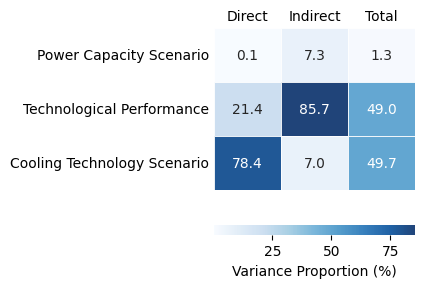

In [10]:
# Plot the variance proportions as a heatmap
# Create DataFrame for heatmap
combined_heatmap_df = pd.DataFrame(
    np.vstack(list(variance_proportions.values())),
    columns=anova_tables["total_water_use_m3"].index,
    index=["Direct", "Indirect", "Total"],
)

# Plot heatmap
fig, ax1 = plt.subplots(1, 1, figsize=(2.6, 3))
sns.heatmap(
    combined_heatmap_df.iloc[:, :-1].T,
    annot=True,
    cmap="Blues",
    fmt=".1f",
    cbar=True,
    alpha=0.9,
    cbar_kws={"label": "Variance Proportion (%)", "orientation": "horizontal"},
    linewidths=0.5,
    ax=ax1,
    yticklabels=["Power Capacity Scenario", "Technological Performance", "Cooling Technology Scenario"],
)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position("top")
ax1.tick_params(length=0)
plt.xticks(rotation=0)
ax1.set_xlabel("")
plt.savefig(FIGURES_DIR / "variance_proportion_water_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()


For variations in WUE and PUE values across data centers


In [11]:
# Load average WUE and PUE results
average_wue_pue = pd.read_csv(RESULTS_DIR / "2_energy_and_water_use/data_centers_average_PUE_WUE_summary.csv")
# Account for operational and planned data centers
average_wue_pue = average_wue_pue[~average_wue_pue["only_operational"]]

In [12]:
# Define formulas for the models
formulas = {
    "electricity_use_efficiency_MWh_MWh": "electricity_use_efficiency_MWh_MWh ~ C(tech_performance) + C(cooling_tech_scenario) + C(ashrae_zone) + C(size)",
    "water_use_efficiency_m3_MWh": "water_use_efficiency_m3_MWh ~ C(tech_performance) + C(cooling_tech_scenario) + C(ashrae_zone) + C(size)",
}

# Fit models and perform ANOVA
anova_tables = {
    key: sm.stats.anova_lm(ols(formula, data=average_wue_pue).fit(), typ=2) for key, formula in formulas.items()
}

# Calculate variance proportions
variance_proportions = {
    key: (anova_table["sum_sq"].to_numpy() / anova_table["sum_sq"].sum()) * 100
    for key, anova_table in anova_tables.items()
}


# Print the ANOVA tables
for key, anova_table in anova_tables.items():
    print(key)
    print(anova_table)
    print()

electricity_use_efficiency_MWh_MWh
                              sum_sq      df            F         PR(>F)
C(tech_performance)        39.237050     2.0  1302.450691   0.000000e+00
C(cooling_tech_scenario)   10.400967     4.0   172.626979  1.517807e-124
C(ashrae_zone)              6.184735    12.0    34.216439   1.042810e-71
C(size)                   206.155619     2.0  6843.213933   0.000000e+00
Residual                   26.118856  1734.0          NaN            NaN

water_use_efficiency_m3_MWh
                               sum_sq      df            F         PR(>F)
C(tech_performance)        345.058882     2.0   284.789796  1.127120e-107
C(cooling_tech_scenario)  3859.047403     4.0  1592.506929   0.000000e+00
C(ashrae_zone)              20.198415    12.0     2.778416   9.273023e-04
C(size)                     20.058399     2.0    16.554935   7.552032e-08
Residual                  1050.480233  1734.0          NaN            NaN



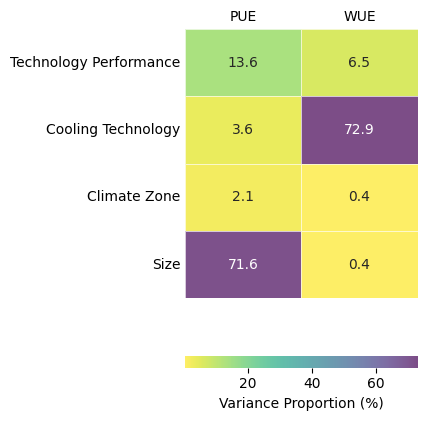

In [13]:
# Plot the variance proportions as a heatmap
# Prepare data for heatmap
combined_heatmap_data = np.vstack(list(variance_proportions.values()))
combined_heatmap_df = pd.DataFrame(
    combined_heatmap_data, columns=anova_tables["electricity_use_efficiency_MWh_MWh"].index, index=["PUE", "WUE"]
)

# Set up the figure and axes
fig, ax1 = plt.subplots(1, 1, figsize=(3, 5))

# Exclude the last data point (residuals)
heatmap_data = combined_heatmap_df.iloc[:, :-1]

# Plot the heatmap with PUE and WUE labels on top
sns.heatmap(
    heatmap_data.T,
    annot=True,
    cmap="viridis_r",
    fmt=".1f",
    cbar=True,
    alpha=0.7,
    cbar_kws={"label": "Variance Proportion (%)", "orientation": "horizontal"},
    linewidths=0.5,
    ax=ax1,
    yticklabels=["Technology Performance", "Cooling Technology", "Climate Zone", "Size"],
)

# Adjust the heatmap to have the labels on top
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position("top")

# Remove the tick lines
ax1.tick_params(length=0)

# Save the figure
plt.savefig(FIGURES_DIR / "average_wue_pue_heatmap.png", dpi=300, bbox_inches="tight")

plt.show()


## Data center summary plots


PLotting the data centers within countries

In [14]:
# Perform a spatial join on countries
data_centers = gpd.sjoin(data_centers, country_boundaries, how="left")
country_boundaries.loc[country_boundaries.index.isin(data_centers["index_right"].dropna().unique()), "col"] = 2

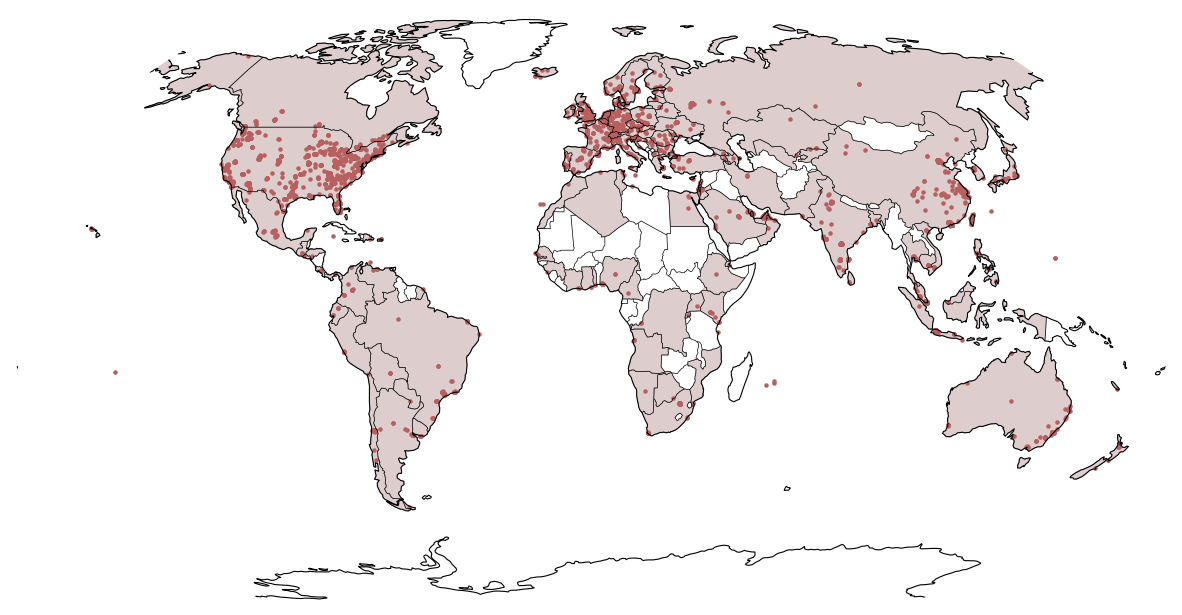

In [15]:
# Plotting data center locations
# Assigning colors
dots_col = "#b86060"  # Dot color
countries_col = "#ddcdcd"  # Country highlight color

# Plot map
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={"projection": ccrs.Robinson()})

# Main map settings
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor="white", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Set global extent
ax.set_global()
ax.spines["geo"].set_edgecolor("black")
ax.spines["geo"].set_linewidth(2)

country_boundaries.plot(ax=ax, color="white", edgecolor="grey", linewidth=0.3)
country_boundaries[country_boundaries["col"] == 2].plot(
    ax=ax, color=countries_col, transform=ccrs.PlateCarree(), edgecolor="grey", linewidth=0.3
)
data_centers.plot(ax=ax, transform=ccrs.PlateCarree(), color=dots_col, markersize=5)

# remove axis
ax.axis("off")

# Save the plot
plt.savefig(FIGURES_DIR / "data_center_locations.png", dpi=300, bbox_inches="tight")

Plotting a barchart of the data centers by continent

In [16]:
# Get the continent from the country code
data_centers["Continent"] = data_centers["ISO_A3_left"].apply(get_continent_from_country)

/var/folders/yd/qf52x40s3gj84v948mly870m0000gn/T/ipykernel_30270/2989226268.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  op = counts["operational"][i]
/var/folders/yd/qf52x40s3gj84v948mly870m0000gn/T/ipykernel_30270/2989226268.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pl = counts["Planned"][i]


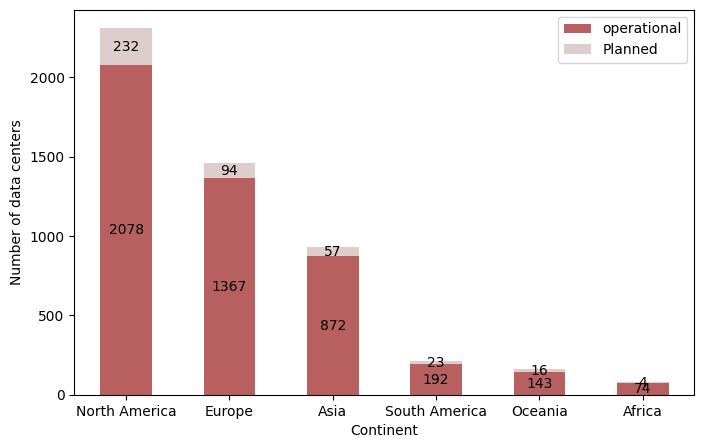

In [18]:
# Plot the number of data centers per continent in a stacked bar chart
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Set colors
dots_col_operational = "#b86060"  # Operational data centers color
dots_col_planned = "#ddcdcd"  # Planned data centers color

# Count the number of operational and planned data centers per continent
operational_counts = data_centers[data_centers["operational"]]["Continent"].value_counts()
planned_counts = data_centers[~data_centers["operational"]]["Continent"].value_counts()

# Combine the counts into a single DataFrame
counts = pd.DataFrame({"operational": operational_counts, "Planned": planned_counts}).fillna(0)

# Plot the stacked bar chart
counts.plot(kind="bar", stacked=True, ax=ax, color=[dots_col_operational, dots_col_planned])

# Translate continent codes to names
continents = {
    "AF": "Africa",
    "AS": "Asia",
    "EU": "Europe",
    "NA": "North America",
    "OC": "Oceania",
    "SA": "South America",
}

# Add labels
ax.set_xticklabels([continents[continent] for continent in counts.index], rotation=0)
ax.set_ylabel("Number of data centers")
ax.set_xlabel("Continent")

# Add labels to the bars
for i in range(len(counts)):
    op = counts["operational"][i]
    pl = counts["Planned"][i]
    ax.text(i, op + pl / 2, str(int(pl)), color="black", ha="center", va="center")
    ax.text(i, op / 2, str(int(op)), color="black", ha="center", va="center")

# Save the plot
plt.savefig(FIGURES_DIR / "data_centers_per_continent.png", dpi=300, bbox_inches="tight")

## Figures energy and water use by country


In [20]:
# Create a subset of the data to represent the baseline scenario
data_center_energy_water_use = data_center_energy_water_use[
    (data_center_energy_water_use["tech_performance"] == "medium")
    & (data_center_energy_water_use["cooling_tech_scenario"] == "baseline")
    & (data_center_energy_water_use["power_scenario"] == "avg")
]

# Remove the index_right column
data_center_energy_water_use = data_center_energy_water_use.drop(columns="index_right")

# Perform a spatial join on countries
data_center_energy_water_use = gpd.sjoin(
    data_center_energy_water_use,
    country_boundaries,
    how="inner",
    predicate="within",
)

In [21]:
# Find the energy use per country
energy_use_per_country = country_boundaries.merge(
    data_center_energy_water_use.groupby("ADMIN").agg({"annual_electricity_use_MWh": "sum"}).reset_index(),
    on="ADMIN",
    how="left",
)

# Convert energy use from MWh to TWh
energy_use_per_country["annual_electricity_use_TWh"] = energy_use_per_country["annual_electricity_use_MWh"] / 1_000_000

# Apply log transformation to the energy use data
energy_use_per_country["log_annual_electricity_use_TWh"] = np.log10(
    energy_use_per_country["annual_electricity_use_TWh"]
)

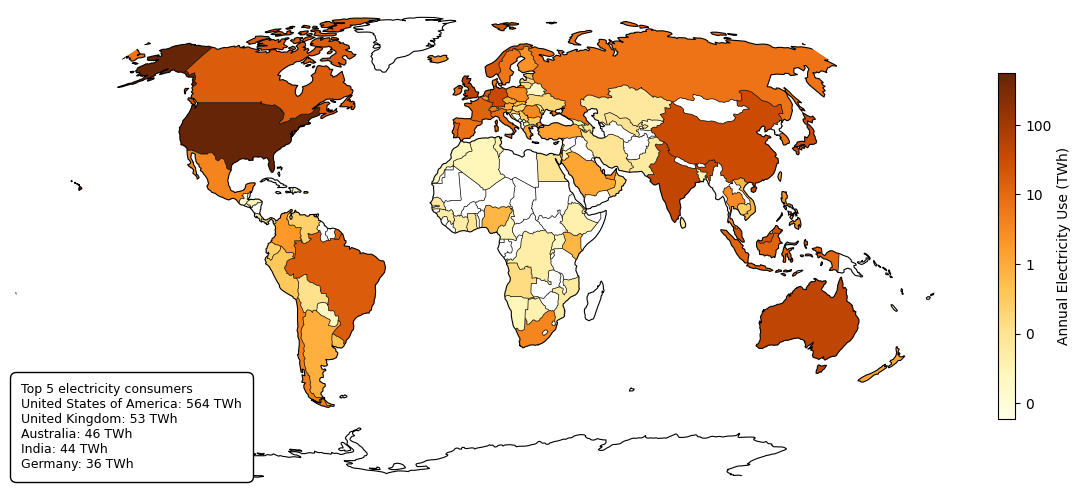

In [22]:
# Plot the energy use per country in log scale
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={"projection": ccrs.Robinson()})
country_boundaries.boundary.plot(ax=ax, color="black", linewidth=0.5)
energy_use_per_country.plot(
    column="log_annual_electricity_use_TWh",
    ax=ax,
    transform=ccrs.PlateCarree(),
    legend=True,
    cmap="YlOrBr",
    legend_kwds={"label": "Annual Electricity Use (TWh)", "shrink": 0.3},
)

# Main map settings
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor="white", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Set global extent
ax.set_global()
ax.spines["geo"].set_edgecolor("black")
ax.spines["geo"].set_linewidth(2)


# Modify the legend to show untransformed values
cbar = ax.get_figure().get_axes()[1]
ticks_loc = cbar.get_yticks()
cbar.yaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
cbar.set_yticklabels([f"{10**tick:.0f}" for tick in ticks_loc])

# Create an extra box with the top 5 countries by energy use in TWh
top_5_energy_use = energy_use_per_country.nlargest(5, "annual_electricity_use_TWh")
top_5_energy_use["text"] = (
    top_5_energy_use["ADMIN"]
    + ": "
    + top_5_energy_use["annual_electricity_use_TWh"].round(0).astype(int).astype(str)
    + " TWh"
)
textstr = "\n".join(top_5_energy_use["text"])

# Create a legend box
anchored_text = AnchoredText(
    "Top 5 electricity consumers\n" + textstr,
    loc="lower left",
    prop={"size": 9},
    frameon=True,
)
anchored_text.patch.set_boxstyle("round,pad=0.5,rounding_size=0.5")
ax.add_artist(anchored_text)

# Remove the axis
ax.set_axis_off()

# Save the plot
plt.savefig(FIGURES_DIR / "data_center_energy_use_by_country.png", dpi=300, bbox_inches="tight")

In [23]:
# Find the water use per country
water_use_per_country = country_boundaries.merge(
    data_center_energy_water_use.groupby("ADMIN").agg({"total_water_use_m3": "sum"}).reset_index(),
    on="ADMIN",
    how="left",
)
# Convert water use from m3 to million m3
water_use_per_country["water_use_million_m3"] = water_use_per_country["total_water_use_m3"] / 1_000_000

# Apply log transformation to the water use data
water_use_per_country["log_water_use_million_m3"] = np.log10(water_use_per_country["water_use_million_m3"])

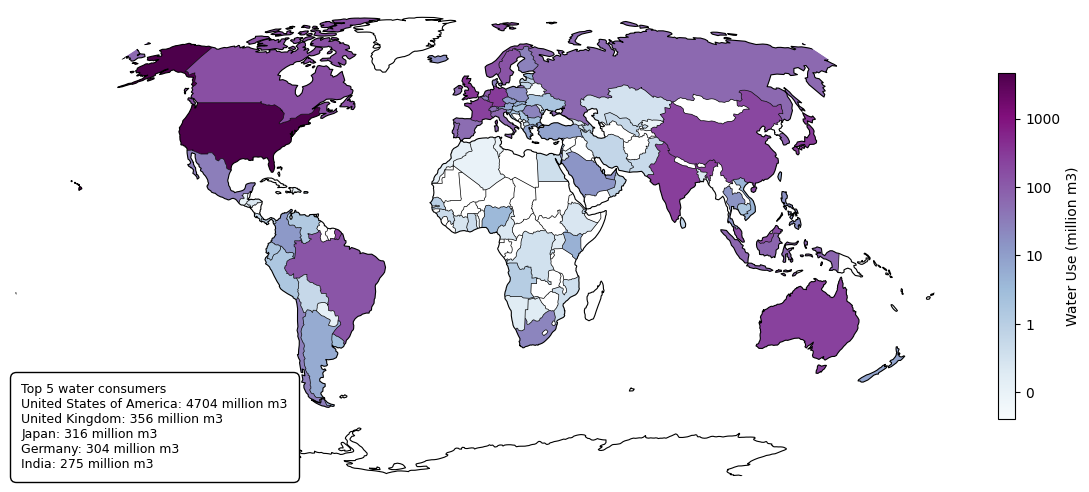

In [24]:
# Plot the water use per country in log scale
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={"projection": ccrs.Robinson()})
country_boundaries.boundary.plot(ax=ax, color="black", linewidth=0.5)
water_use_per_country.plot(
    column="log_water_use_million_m3",
    ax=ax,
    transform=ccrs.PlateCarree(),
    legend=True,
    cmap="BuPu",
    legend_kwds={"label": "Water Use (million m3)", "shrink": 0.3},
)

# Main map settings
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor="white", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Set global extent
ax.set_global()
ax.spines["geo"].set_edgecolor("black")
ax.spines["geo"].set_linewidth(2)


# Modify the legend to show untransformed values
cbar = ax.get_figure().get_axes()[1]
ticks_loc = cbar.get_yticks()
cbar.yaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
cbar.set_yticklabels([f"{10**tick:.0f}" for tick in ticks_loc])

# Create an extra box with the top 5 countries by water use in million m3
top_5_water_use = water_use_per_country.nlargest(5, "water_use_million_m3")
top_5_water_use["text"] = (
    top_5_water_use["ADMIN"]
    + ": "
    + top_5_water_use["water_use_million_m3"].round(0).astype(int).astype(str)
    + " million m3"
)
textstr = "\n".join(top_5_water_use["text"])

# Create a legend box
anchored_text = AnchoredText(
    "Top 5 water consumers\n" + textstr,
    loc="lower left",
    prop={"size": 9},
    frameon=True,
)
anchored_text.patch.set_boxstyle("round,pad=0.5,rounding_size=0.5")
ax.add_artist(anchored_text)

# Remove the axis
ax.set_axis_off()

# Save the plot
plt.savefig(FIGURES_DIR / "data_center_water_use_by_country.png", dpi=300, bbox_inches="tight")

# Mapping water use per basin


In [ ]:
# Read the watershed sub-basin shapefile
basins_level5 = gpd.read_file(INPUTS_DIR / "BasinATLAS_Data_v10/BasinATLAS_v10_lev05.shp", crs=WGS84_CRS)

# Read in the water use data
water_use_dcs_pps = read_gdf_from_csv(RESULTS_DIR / "2_energy_and_water_use/water_use_dcs_pps_baseline.csv")
water_use_dcs_pps_operational = read_gdf_from_csv(
    RESULTS_DIR / "2_energy_and_water_use/water_use_dcs_pps_operational_baseline.csv"
)
water_use_dcs_pps_planned = read_gdf_from_csv(
    RESULTS_DIR / "2_energy_and_water_use/water_use_dcs_pps_planned_baseline.csv"
)

In [ ]:
# Spatial join the water use data to the basins to calculate water use by basin
water_use_per_basin_operational = calculate_water_use_by_basin(water_use_dcs_pps_operational, basins_level5)
water_use_per_basin_planned = calculate_water_use_by_basin(water_use_dcs_pps_planned, basins_level5)

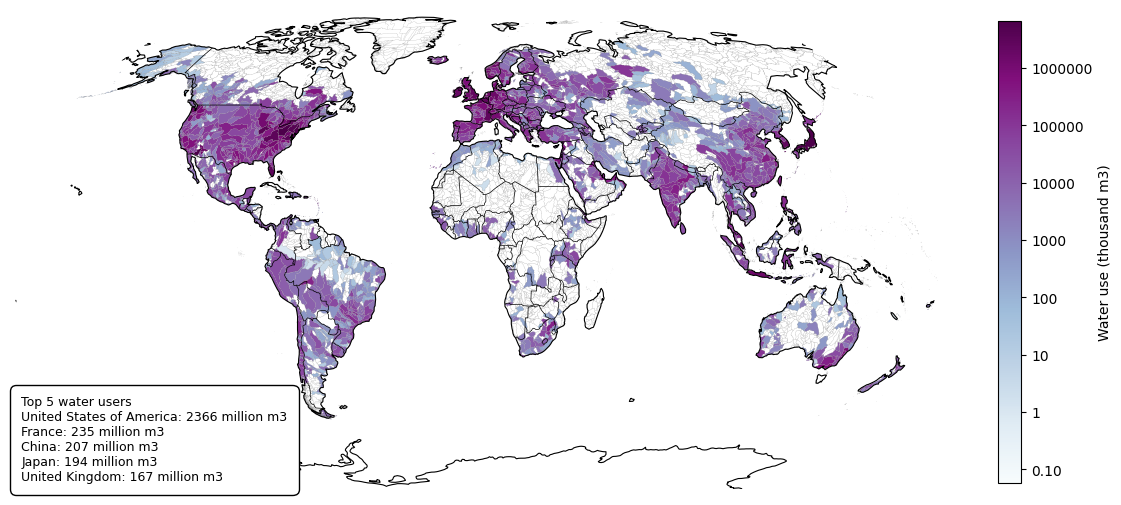

In [20]:
# Plot the water use map for planned data centers
plot_water_use_map(
    water_use_per_basin_operational,
    basins_level5,
    data_center_energy_water_use,
    figure_dir=FIGURES_DIR,
    status="operational",
    figsize=(15, 15),
    cmap="BuPu",
)

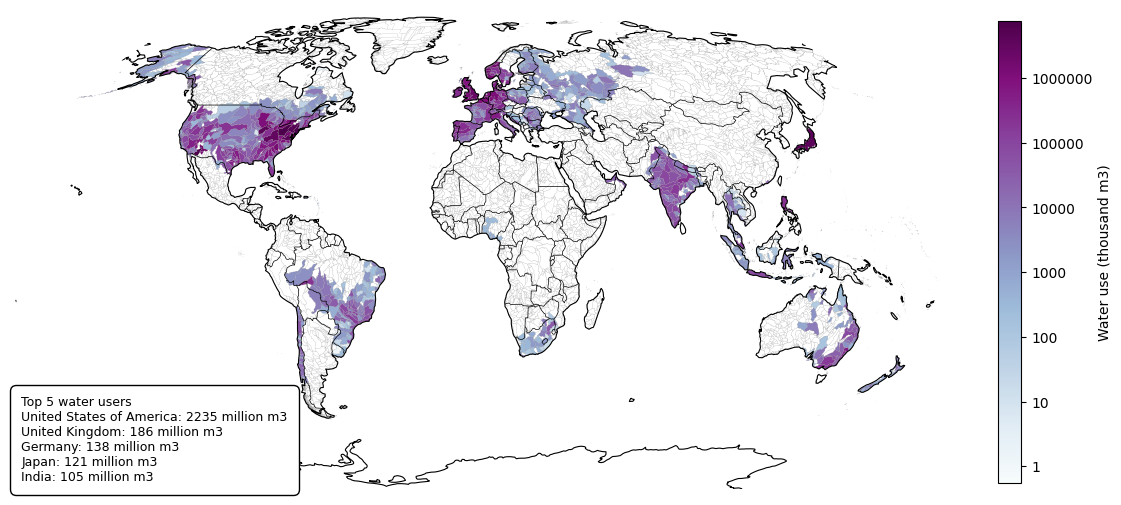

In [21]:
# Plot the water use map for operational data centers
plot_water_use_map(
    water_use_per_basin_planned,
    basins_level5,
    data_center_energy_water_use,
    figure_dir=FIGURES_DIR,
    status="planned",
    figsize=(15, 15),
    cmap="BuPu",
)

In [ ]:
# What percent of basins have non-missing water use data?
percent_not_missing = 100 * water_use_per_basin_operational["dc_annual_water_use_m3"].notna().sum() / len(basins_level5)
print(f"Percent of basins with data center water use: {percent_not_missing:.2f}%")

## Data center vulnerability to water scarcity figures


Mapping the areas with the greatest increases in water scarcity risk

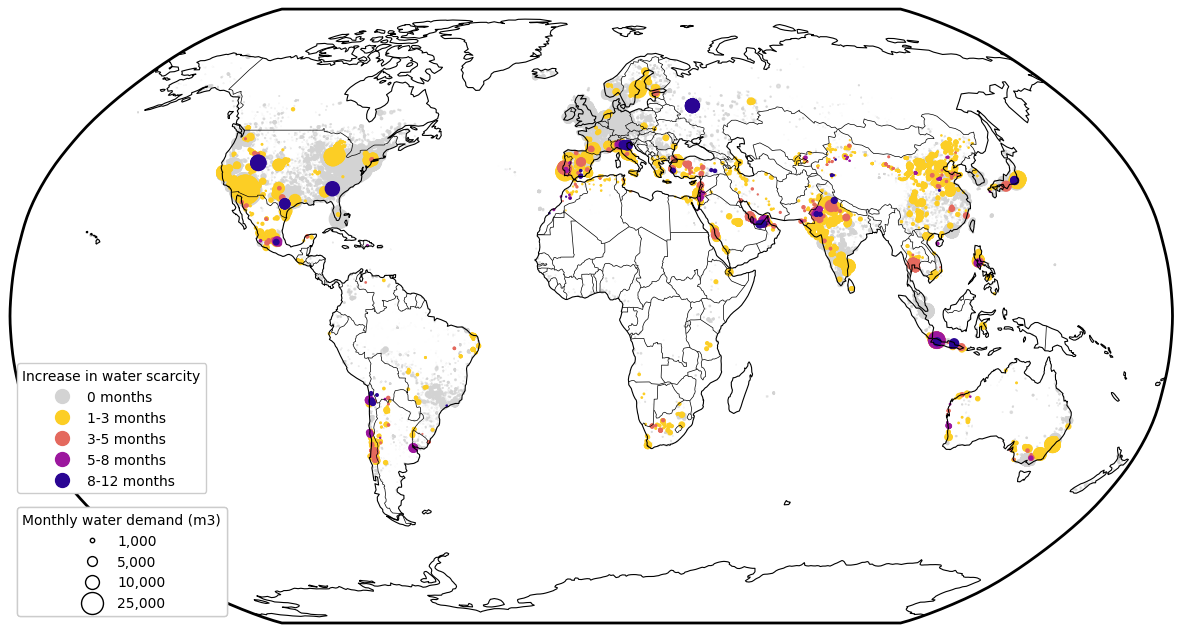

In [76]:
# for 1.5C scenario
plot_water_scarcity_at_extraction_sites(
    water_scarcity_summary["1_5C"],
    FIGURES_DIR,
    warming_scenario="1_5C",
)

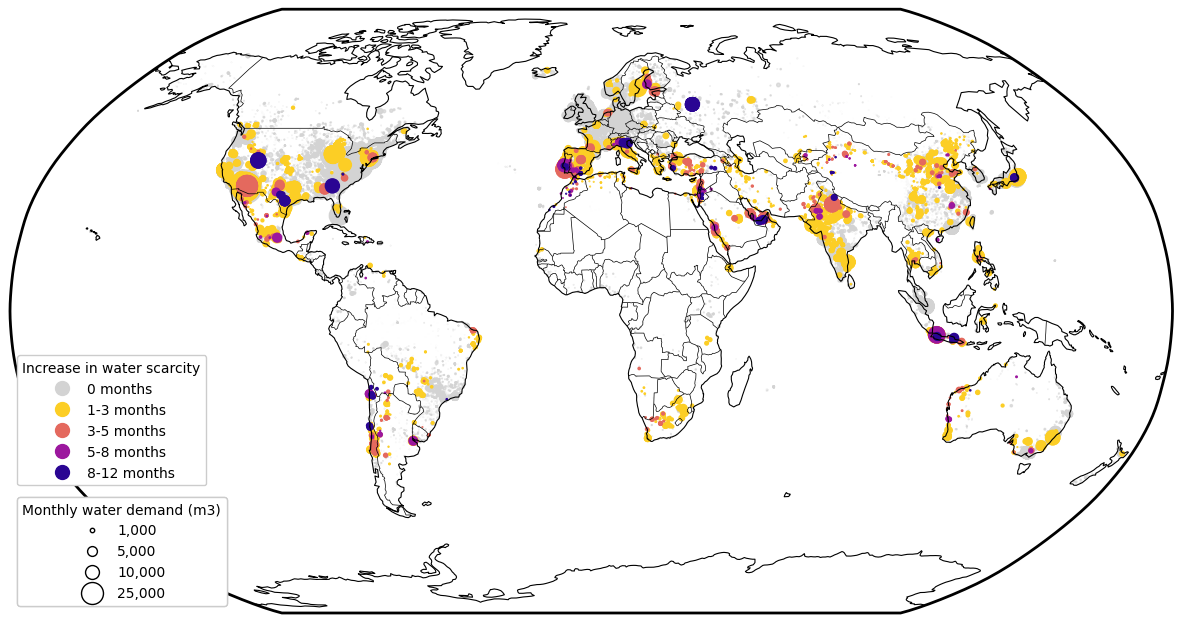

In [77]:
# for 2.0C scenario
plot_water_scarcity_at_extraction_sites(
    water_scarcity_summary["2_0C"],
    FIGURES_DIR,
    warming_scenario="2_0C",
)

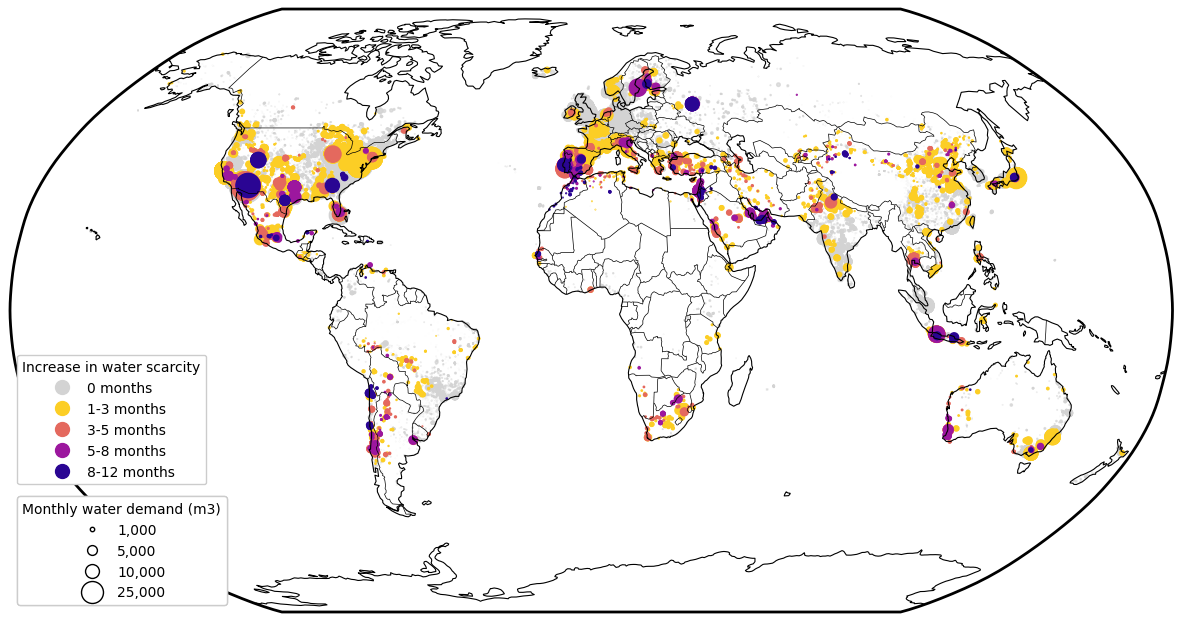

In [78]:
# for 3.2C scenario
plot_water_scarcity_at_extraction_sites(
    water_scarcity_summary["3_2C"],
    FIGURES_DIR,
    warming_scenario="3_2C",
)

Plotting a barchart of the total capacity at increased risk

In [4]:
# Calculate the percentage of months with a WSI increase for each scenario
# Define scenarios and their corresponding DataFrames
future_scenarios_dict = {
    "1.5°C": water_scarcity_summary_dc["1_5C"],
    "2.0°C": water_scarcity_summary_dc["2_0C"],
    "3.2°C": water_scarcity_summary_dc["3_2C"],
}

# Initialize results DataFrame
water_scarcity_counts_direct = pd.DataFrame({"Scenario": list(future_scenarios_dict.keys())})

# Calculate monthly percentages
for month in range(1, 13):
    water_scarcity_counts_direct[f"{month} month"] = [
        100 * (df.loc[df["months_WSI_increase"] == month, "tcp_mw"].sum() / df["tcp_mw"].sum())
        for df in future_scenarios_dict.values()
    ]

# Calculate error data
error_data_direct = pd.DataFrame(
    {
        "Scenario": list(future_scenarios_dict.keys()),
        "Direct_increase_error": [
            100
            * (
                df.loc[df["months_WSI_0p6_increase"] > 0, "tcp_mw"].sum()
                - df.loc[df["months_WSI_increase"] > 0, "tcp_mw"].sum()
            )
            / df["tcp_mw"].sum()
            for df in future_scenarios_dict.values()
        ],
    }
)

In [6]:
# Calculate the share of each power plant's capacity that is affected by increased water scarcity
for scenario in GLOBAL_WARMING_SCENARIOS_FUTURE:
    water_scarcity_summary[scenario] = calculate_pp_increased_ws_share(water_scarcity_summary[scenario], power_plants)

In [7]:
# Calculate the total capacity at risk for each data center
for scenario in GLOBAL_WARMING_SCENARIOS_FUTURE:
    water_scarcity_summary[scenario] = calculate_total_data_center_capacity_at_risk(water_scarcity_summary[scenario])

In [8]:
# Calculate the water scarcity increase counts as percentages for each month from 1 to 12
water_scarcity_counts_indirect = pd.DataFrame({"Scenario": ["1.5°C", "2.0°C", "3.2°C"]})

for month in range(1, 13):
    water_scarcity_counts_indirect[f"{month} month"] = [
        100
        * (
            water_scarcity_summary[scenario]
            .loc[water_scarcity_summary[scenario]["months_WSI_increase"] == month, "tcp_mw_share_pp"]
            .sum()
            / water_scarcity_summary[scenario]["tcp_mw_share_pp"].sum()
        )
        for scenario in GLOBAL_WARMING_SCENARIOS_FUTURE
    ]

# Add errors based on EFR = 0.6
error_data_indirect = pd.DataFrame({"Scenario": ["1.5°C", "2.0°C", "3.2°C"]})
error_data_indirect["Direct_increase_error"] = [
    100
    * (
        (
            water_scarcity_summary[scenario]
            .loc[water_scarcity_summary[scenario]["months_WSI_0p6_increase"] > 0, "tcp_mw_share_pp"]
            .sum()
        )
        - (
            water_scarcity_summary[scenario]
            .loc[water_scarcity_summary[scenario]["months_WSI_increase"] > 0, "tcp_mw_share_pp"]
            .sum()
        )
    )
    / water_scarcity_summary[scenario]["tcp_mw_share_pp"].sum()
    for scenario in GLOBAL_WARMING_SCENARIOS_FUTURE
]


In [9]:
# Calculate the total global capacity at risk for each scenario
water_scarcity_total_capacity_at_risk = pd.DataFrame(
    {
        "Scenario": ["1.5°C", "2.0°C", "3.2°C"],
        "Total_capacity_at_risk": [
            100
            * water_scarcity_summary[scenario]["total_capacity_at_risk"].sum()
            / water_scarcity_summary[scenario]["tcp_mw"].sum()
            for scenario in GLOBAL_WARMING_SCENARIOS_FUTURE
        ],
    }
)

error_data_total = pd.DataFrame(
    {
        "Scenario": ["1.5°C", "2.0°C", "3.2°C"],
        "Total_capacity_at_risk_error": [
            100
            * (
                water_scarcity_summary[scenario]["total_capacity_at_risk_0p6"].sum()
                / water_scarcity_summary[scenario]["tcp_mw"].sum()
            )
            - 100
            * (
                water_scarcity_summary[scenario]["total_capacity_at_risk"].sum()
                / water_scarcity_summary[scenario]["tcp_mw"].sum()
            )
            for scenario in GLOBAL_WARMING_SCENARIOS_FUTURE
        ],
    }
)

total_tcp_gw = water_scarcity_summary["1_5C"]["tcp_mw"].sum() / 1000


Total capacity at risk for 1.5°C: 22 %
Total capacity at risk for 2.0°C: 20 %
Total capacity at risk for 3.2°C: 32 %


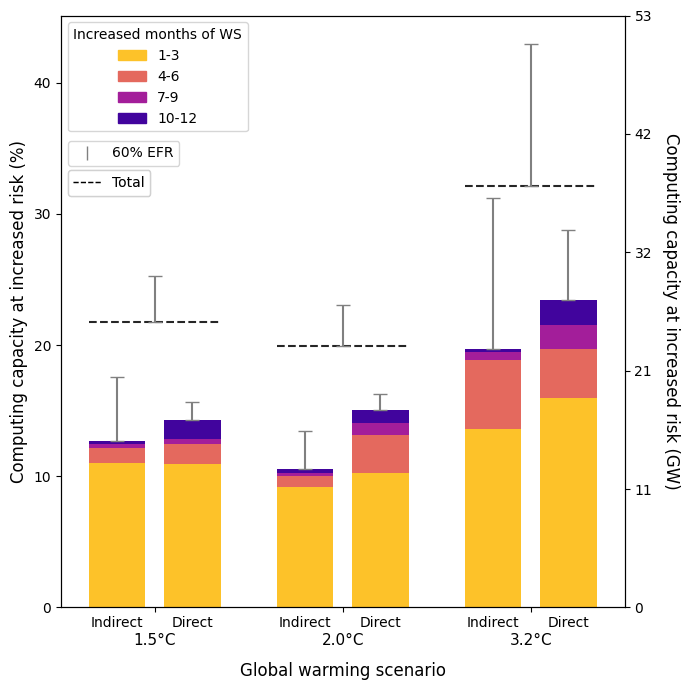

In [11]:
# Plot the percent of data center capacity at increased risk of water scarcity
# Define future scenarios for plotting
future_scenarios_for_plotting = ["1.5°C", "2.0°C", "3.2°C"]

# Define bins for months
bins = [(1, 3), (4, 6), (7, 9), (10, 12)]
bin_labels = ["1-3", "4-6", "7-9", "10-12"]
num_bins = len(bins)

# Define colors (same for both Direct and Indirect)
colors = plt.cm.plasma_r(np.linspace(0.13, 0.9, num_bins))

# Create figure
fig, ax1 = plt.subplots(figsize=(7, 7))

# Define x positions for the bars
x = np.arange(len(future_scenarios_for_plotting))

# Define bar width
bar_width = 0.3

# Define a gap between bars
gap = 0.1  # Adjust for spacing between bars

# Adjust x positions for direct and indirect bars
x_direct = x + (bar_width / 2 + gap / 2)
x_indirect = x - (bar_width / 2 + gap / 2)

# Initialize bottom values for stacking
bottom_direct = np.zeros(len(future_scenarios_for_plotting))
bottom_indirect = np.zeros(len(future_scenarios_for_plotting))

# Plot Indirect bars with stacking (dashed edges)
for i, (start, end) in enumerate(bins):
    bin_data_indirect = water_scarcity_counts_indirect.iloc[:, start : end + 1].sum(axis=1)
    ax1.bar(
        x_indirect,
        bin_data_indirect,
        bottom=bottom_indirect,
        width=bar_width,
        color=colors[i],
        label=bin_labels[i] if i == 0 else "",
    )
    bottom_indirect += bin_data_indirect

# Plot Direct bars with stacking
for i, (start, end) in enumerate(bins):
    bin_data_direct = water_scarcity_counts_direct.iloc[:, start : end + 1].sum(axis=1)
    ax1.bar(x_direct, bin_data_direct, bottom=bottom_direct, width=bar_width, color=colors[i])
    bottom_direct += bin_data_direct

# Plot Total capacity at risk, as a horizontal line for each scenario
for i, scenario in enumerate(future_scenarios_for_plotting):
    total_capacity = water_scarcity_total_capacity_at_risk.loc[
        water_scarcity_total_capacity_at_risk["Scenario"] == scenario, "Total_capacity_at_risk"
    ].to_numpy()[0]
    ax1.hlines(
        total_capacity,
        x_indirect[i] - bar_width / 2,
        x_direct[i] + bar_width / 2,
        color="black",
        linestyle="--",
        linewidth=1.5,
        alpha=0.85,
    )
    error = error_data_total.loc[error_data_total["Scenario"] == scenario, "Total_capacity_at_risk_error"].values[0]
    ax1.errorbar(x[i], total_capacity, yerr=[[0], [error]], fmt="none", ecolor="grey", capsize=5)
    # Print the total capacity at risk
    print(f"Total capacity at risk for {scenario}: {total_capacity:.0f} %")

# Add error bars
for i, scenario in enumerate(future_scenarios_for_plotting):
    total_direct = water_scarcity_counts_direct.iloc[i, 1:].sum()
    total_indirect = water_scarcity_counts_indirect.iloc[i, 1:].sum()

    direct_error = error_data_direct.loc[error_data_direct["Scenario"] == scenario, "Direct_increase_error"].values[
        0
    ]
    indirect_error = error_data_indirect.loc[
        error_data_indirect["Scenario"] == scenario, "Direct_increase_error"
    ].values[0]
    ax1.errorbar(x_direct[i], total_direct, yerr=[[0], [direct_error]], fmt="none", ecolor="grey", capsize=5)
    ax1.errorbar(x_indirect[i], total_indirect, yerr=[[0], [indirect_error]], fmt="none", ecolor="grey", capsize=5)

# Labels and formatting
ax1.set_ylabel("Computing capacity at increased risk (%)", fontsize=12)
ax1.set_xlabel("Global warming scenario", fontsize=12, labelpad=10)
ax1.set_xticks(x)
ax1.set_xticklabels(future_scenarios_for_plotting, rotation=0, fontsize=11)
ax1.tick_params(axis="x", labelrotation=0, pad=15)

# Add labels for Direct and Indirect above x-axis tick labels
for i in range(len(future_scenarios_for_plotting)):
    ax1.text(x_direct[i], -1.2, "Direct", ha="center", va="center", fontsize=10, color="black")
    ax1.text(x_indirect[i], -1.2, "Indirect", ha="center", va="center", fontsize=10, color="black")

# Adjust x-axis limits to ensure all bars are in view
ax1.set_xlim(-0.5, len(future_scenarios_for_plotting) - 0.5)

# Add legend for the bins
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(len(bins))]
legend1 = ax1.legend(handles, bin_labels, title="Increased months of WS", loc="upper left", fontsize=10)
ax1.add_artist(legend1)

# Add error bar to the legend
error_handle = plt.Line2D([0], [0], color="grey", marker="|", markersize=10, linestyle="", label="60% EFR")
legend2 = ax1.legend(handles=[error_handle], loc="upper left", fontsize=10, bbox_to_anchor=(0, 0.8))
ax1.add_artist(legend2)

# Add red line to the legend
total_handle = plt.Line2D([0], [0], color="black", linestyle="--", linewidth=1, label="Total")
legend3 = ax1.legend(handles=[total_handle], loc="upper left", fontsize=10, bbox_to_anchor=(0, 0.75))
ax1.add_artist(legend3)

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Computing capacity at increased risk (GW)", fontsize=12, rotation=270, labelpad=20)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels([f"{ytick * total_tcp_gw / 100:.0f}" for ytick in ax1.get_yticks()])

# Save the plot
plt.savefig(FIGURES_DIR / "computing_capacity_increased_ws_risk_barchart.png", bbox_inches="tight", dpi=300)

# Layout adjustments
plt.tight_layout()
plt.show()

## Exacerbation water scarcity risk figures


Mapping the areas with the greatest increases in water scarcity risk due to data center water use

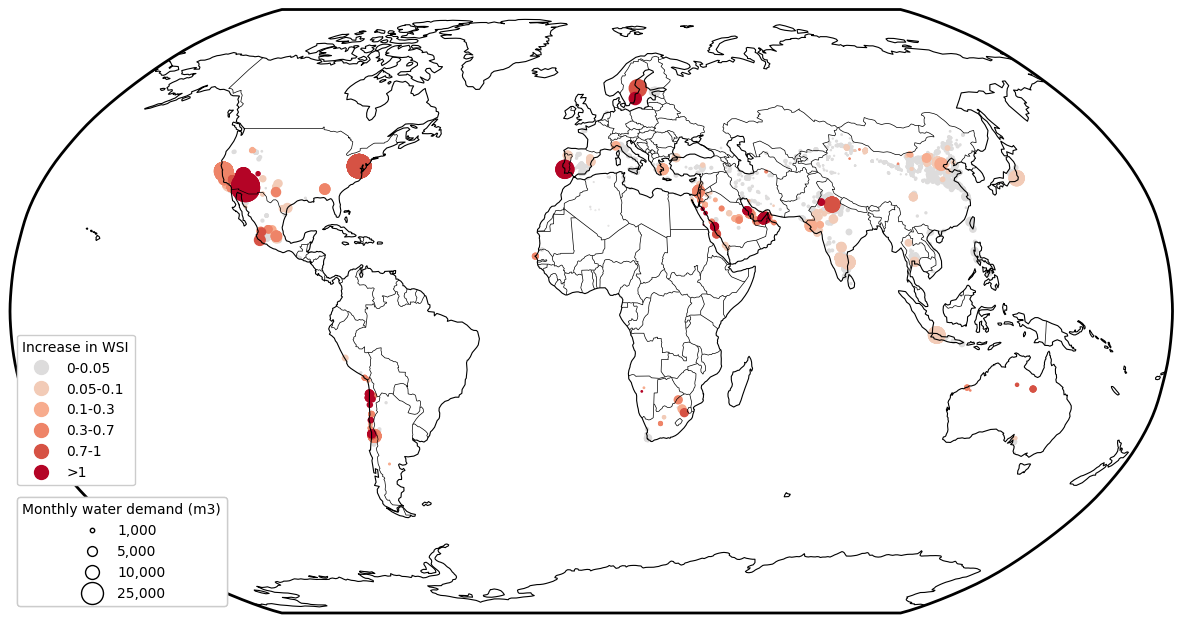

In [12]:
# Plot the relative index for the historical scenario
plot_relative_increase_ws_map(water_scarcity_summary["hist"], FIGURES_DIR, "hist")

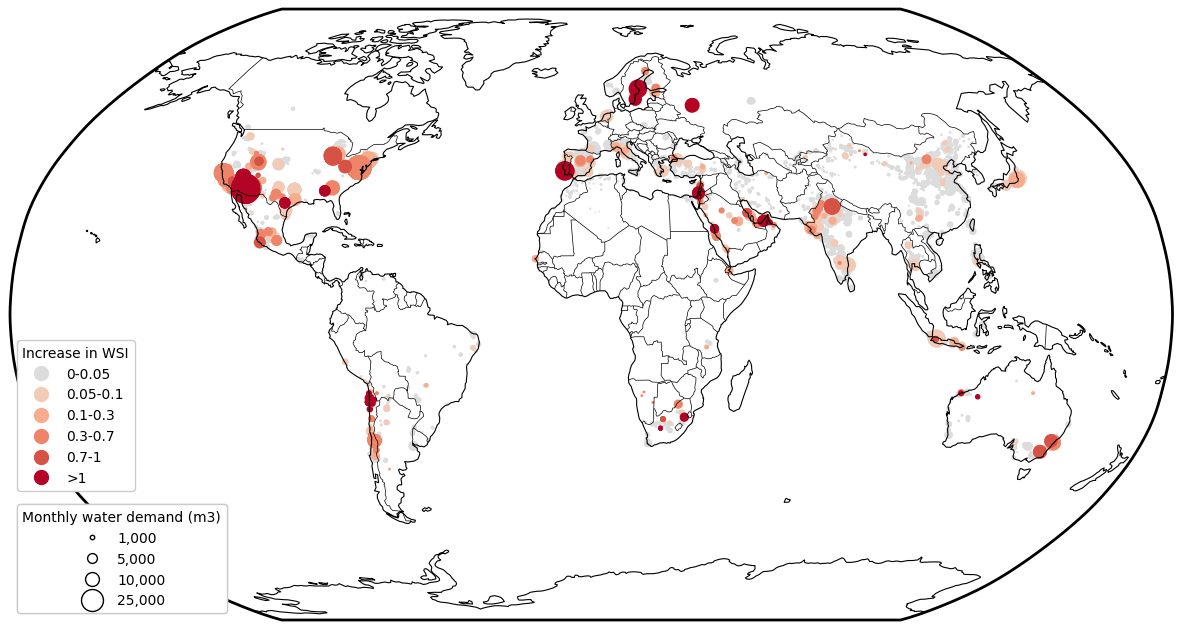

In [13]:
# Plot the relative index for the 1.5°C scenario
plot_relative_increase_ws_map(water_scarcity_summary["1_5C"], FIGURES_DIR, "1_5C")

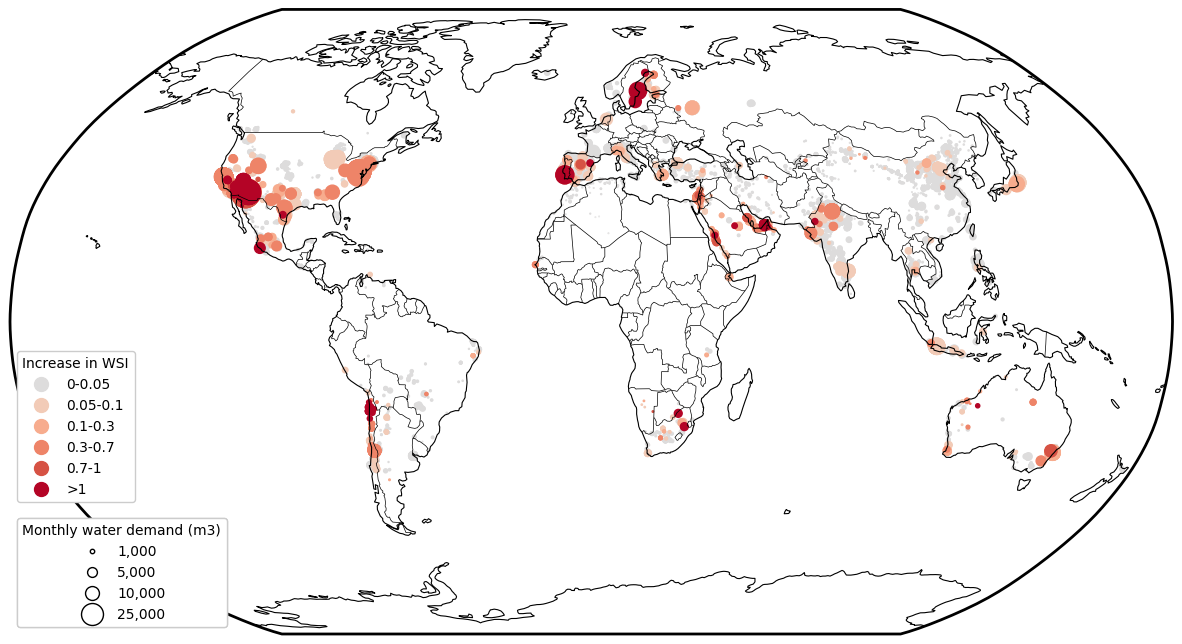

In [14]:
# Plot the relative index for the 2.0°C scenario
plot_relative_increase_ws_map(water_scarcity_summary["2_0C"], FIGURES_DIR, "2_0C")

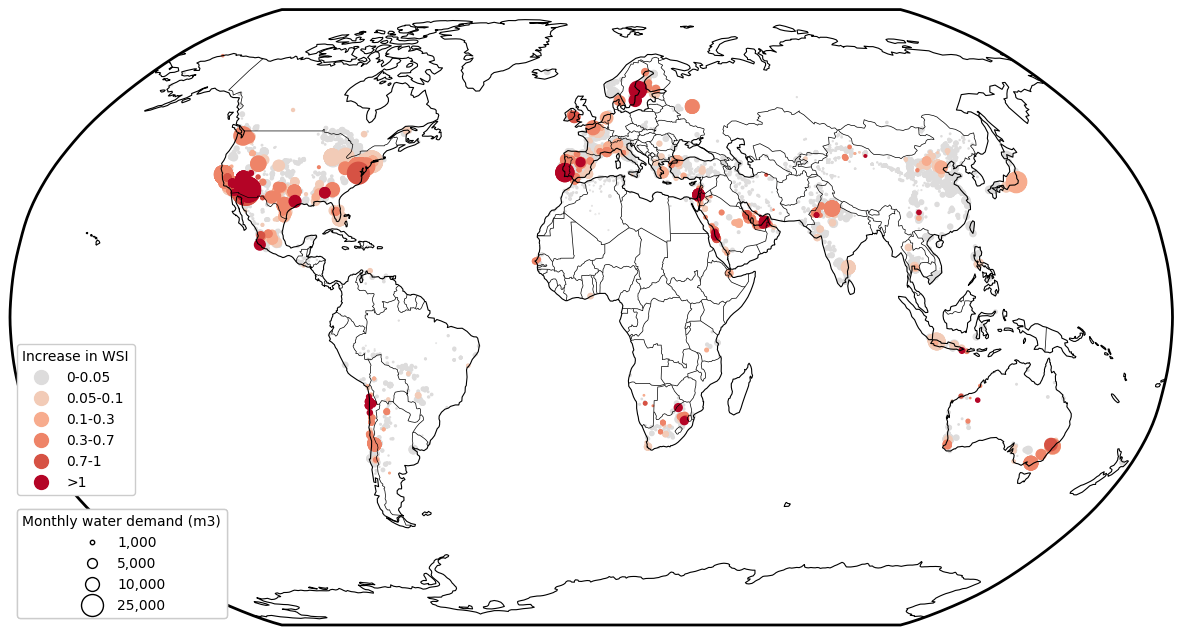

In [15]:
# Plot the relative index for the 3.2°C scenario
plot_relative_increase_ws_map(water_scarcity_summary["3_2C"], FIGURES_DIR, "3_2C")

Plotting a bar chart of the percent of data centers which exacerbate or tip water scarcity risk

In [4]:
# Declare the count of all data centers
total_dc = water_scarcity_summary_dc["3_2C"].shape[0]

# Find the percent of data centers which tip the region into water scarcity
tip_into_water_scarcity_counts = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})
error_tip_into_water_scarcity = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})

for month in range(1, 13):
    tip_into_water_scarcity_counts[f"{month} month"] = [
        100
        * (
            water_scarcity_summary_dc[scenario]
            .loc[
                (water_scarcity_summary_dc[scenario]["months_WSI"] == 0)
                & (water_scarcity_summary_dc[scenario]["months_WSI_dc"] == month)
            ]
            .shape[0]
            / total_dc
        )
        for scenario in GLOBAL_WARMING_SCENARIOS
    ]

    error_tip_into_water_scarcity[f"{month} month"] = [
        abs(
            100
            * (
                water_scarcity_summary_dc[scenario]
                .loc[
                    (water_scarcity_summary_dc[scenario]["months_WSI_0p6"] == 0)
                    & (water_scarcity_summary_dc[scenario]["months_WSI_dc_0p6"] == month)
                ]
                .shape[0]
                / total_dc
                - (
                    water_scarcity_summary_dc[scenario]
                    .loc[
                        (water_scarcity_summary_dc[scenario]["months_WSI"] == 0)
                        & (water_scarcity_summary_dc[scenario]["months_WSI_dc"] == month)
                    ]
                    .shape[0]
                    / total_dc
                )
            )
        )
        for scenario in GLOBAL_WARMING_SCENARIOS
    ]


In [5]:
# Find the percent of data centers which exacerbate water scarcity
exacerbate_water_scarcity_counts = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})
error_exacerbate_water_scarcity = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})

for month in range(1, 13):
    exacerbate_water_scarcity_counts[f"{month} month"] = [
        100 * (df.loc[(df["months_WSI"] > 0) & ((df["months_WSI_dc"] - df["months_WSI"]) == month)].shape[0] / total_dc)
        for df in water_scarcity_summary_dc.values()
    ]

    error_exacerbate_water_scarcity[f"{month} month"] = [
        abs(
            100
            * (
                df.loc[(df["months_WSI_0p6"] > 0) & ((df["months_WSI_dc_0p6"] - df["months_WSI_0p6"]) == month)].shape[
                    0
                ]
                / total_dc
                - (
                    df.loc[(df["months_WSI"] > 0) & ((df["months_WSI_dc"] - df["months_WSI"]) == month)].shape[0]
                    / total_dc
                )
            )
        )
        for df in water_scarcity_summary_dc.values()
    ]


In [6]:
# Declare the count of all power plants
total_pp = water_scarcity_summary_pp["3_2C"].shape[0]

# Initialize DataFrames for results
tip_into_water_scarcity_counts_pp = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})
error_tip_into_water_scarcity_pp = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})
exacerbate_water_scarcity_counts_pp = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})
error_exacerbate_water_scarcity_pp = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})

# Define scenarios list
scenarios_pp = [water_scarcity_summary_pp[scenario] for scenario in GLOBAL_WARMING_SCENARIOS]

# Calculate percentages and errors for each month
for month in range(1, 13):
    tip_into_water_scarcity_counts_pp[f"{month} month"] = [
        100 * (scenario.loc[(scenario["months_WSI"] == 0) & (scenario["months_WSI_dc"] == month)].shape[0] / total_pp)
        for scenario in scenarios_pp
    ]

    error_tip_into_water_scarcity_pp[f"{month} month"] = [
        abs(
            100
            * (
                scenario.loc[(scenario["months_WSI_0p6"] == 0) & (scenario["months_WSI_dc_0p6"] == month)].shape[0]
                / total_pp
                - (
                    scenario.loc[(scenario["months_WSI"] == 0) & (scenario["months_WSI_dc"] == month)].shape[0]
                    / total_pp
                )
            )
        )
        for scenario in scenarios_pp
    ]

    exacerbate_water_scarcity_counts_pp[f"{month} month"] = [
        100
        * (
            scenario.loc[
                (scenario["months_WSI"] > 0) & ((scenario["months_WSI_dc"] - scenario["months_WSI"]) == month)
            ].shape[0]
            / total_pp
        )
        for scenario in scenarios_pp
    ]

    error_exacerbate_water_scarcity_pp[f"{month} month"] = [
        abs(
            100
            * (
                scenario.loc[
                    (scenario["months_WSI_0p6"] > 0)
                    & ((scenario["months_WSI_dc_0p6"] - scenario["months_WSI_0p6"]) == month)
                ].shape[0]
                / total_pp
                - (
                    scenario.loc[
                        (scenario["months_WSI"] > 0) & ((scenario["months_WSI_dc"] - scenario["months_WSI"]) == month)
                    ].shape[0]
                    / total_pp
                )
            )
        )
        for scenario in scenarios_pp
    ]

In [7]:
scenarios_for_plotting = ["Historical", "1.5°C", "2.0°C", "3.2°C"]
bins = [(1, 3), (4, 6), (7, 9), (10, 12)]
bin_labels = ["1-3", "4-6", "7-9", "10-12"]
colors = plt.cm.Reds(np.linspace(0.2, 1, len(bins)))

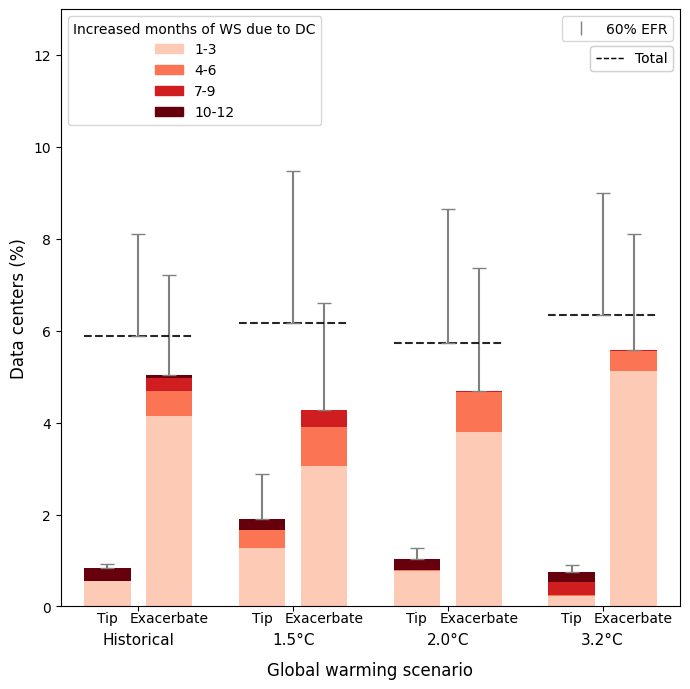

In [15]:
# Bar chart of data centers tipping into and exacerbating water scarcity
plot_exacerbate_tip_water_scarcity_barchart(
    GLOBAL_WARMING_SCENARIOS,
    bins,
    bin_labels,
    colors,
    tip_into_water_scarcity_counts,
    exacerbate_water_scarcity_counts,
    error_tip_into_water_scarcity,
    error_exacerbate_water_scarcity,
    FIGURES_DIR,
)